In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [46]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd1']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [47]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [34]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.09916e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.27it/s]


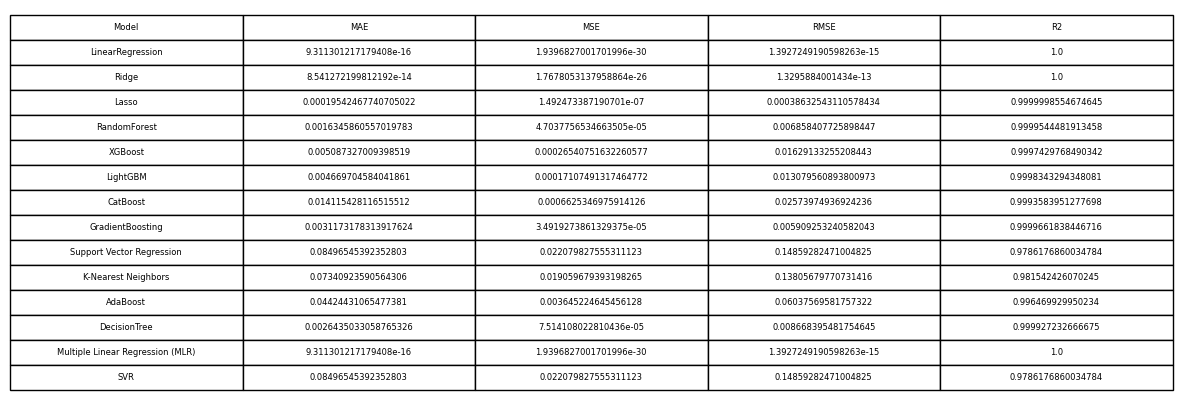

In [35]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

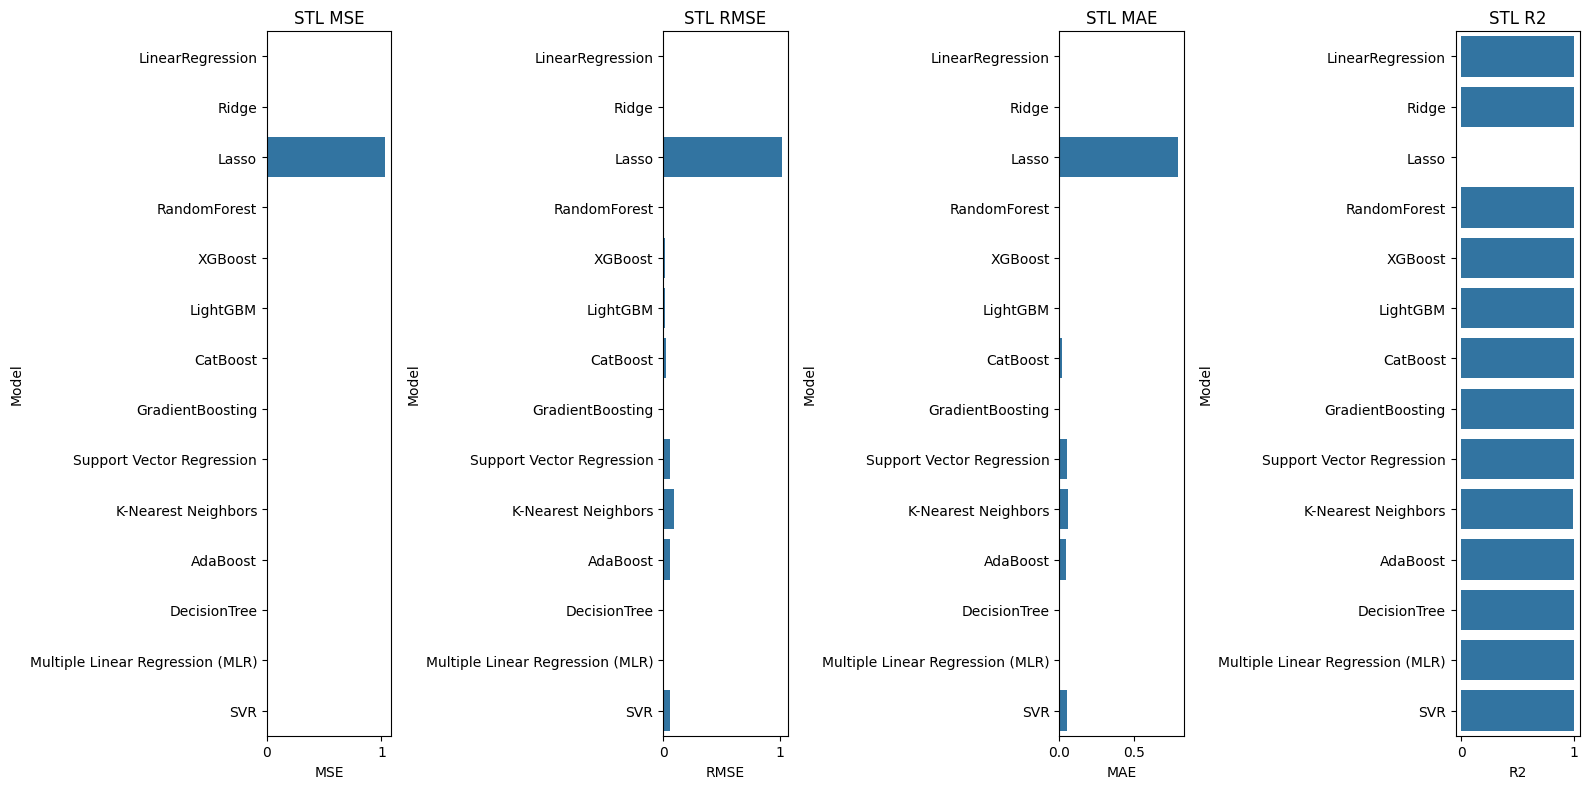

In [9]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

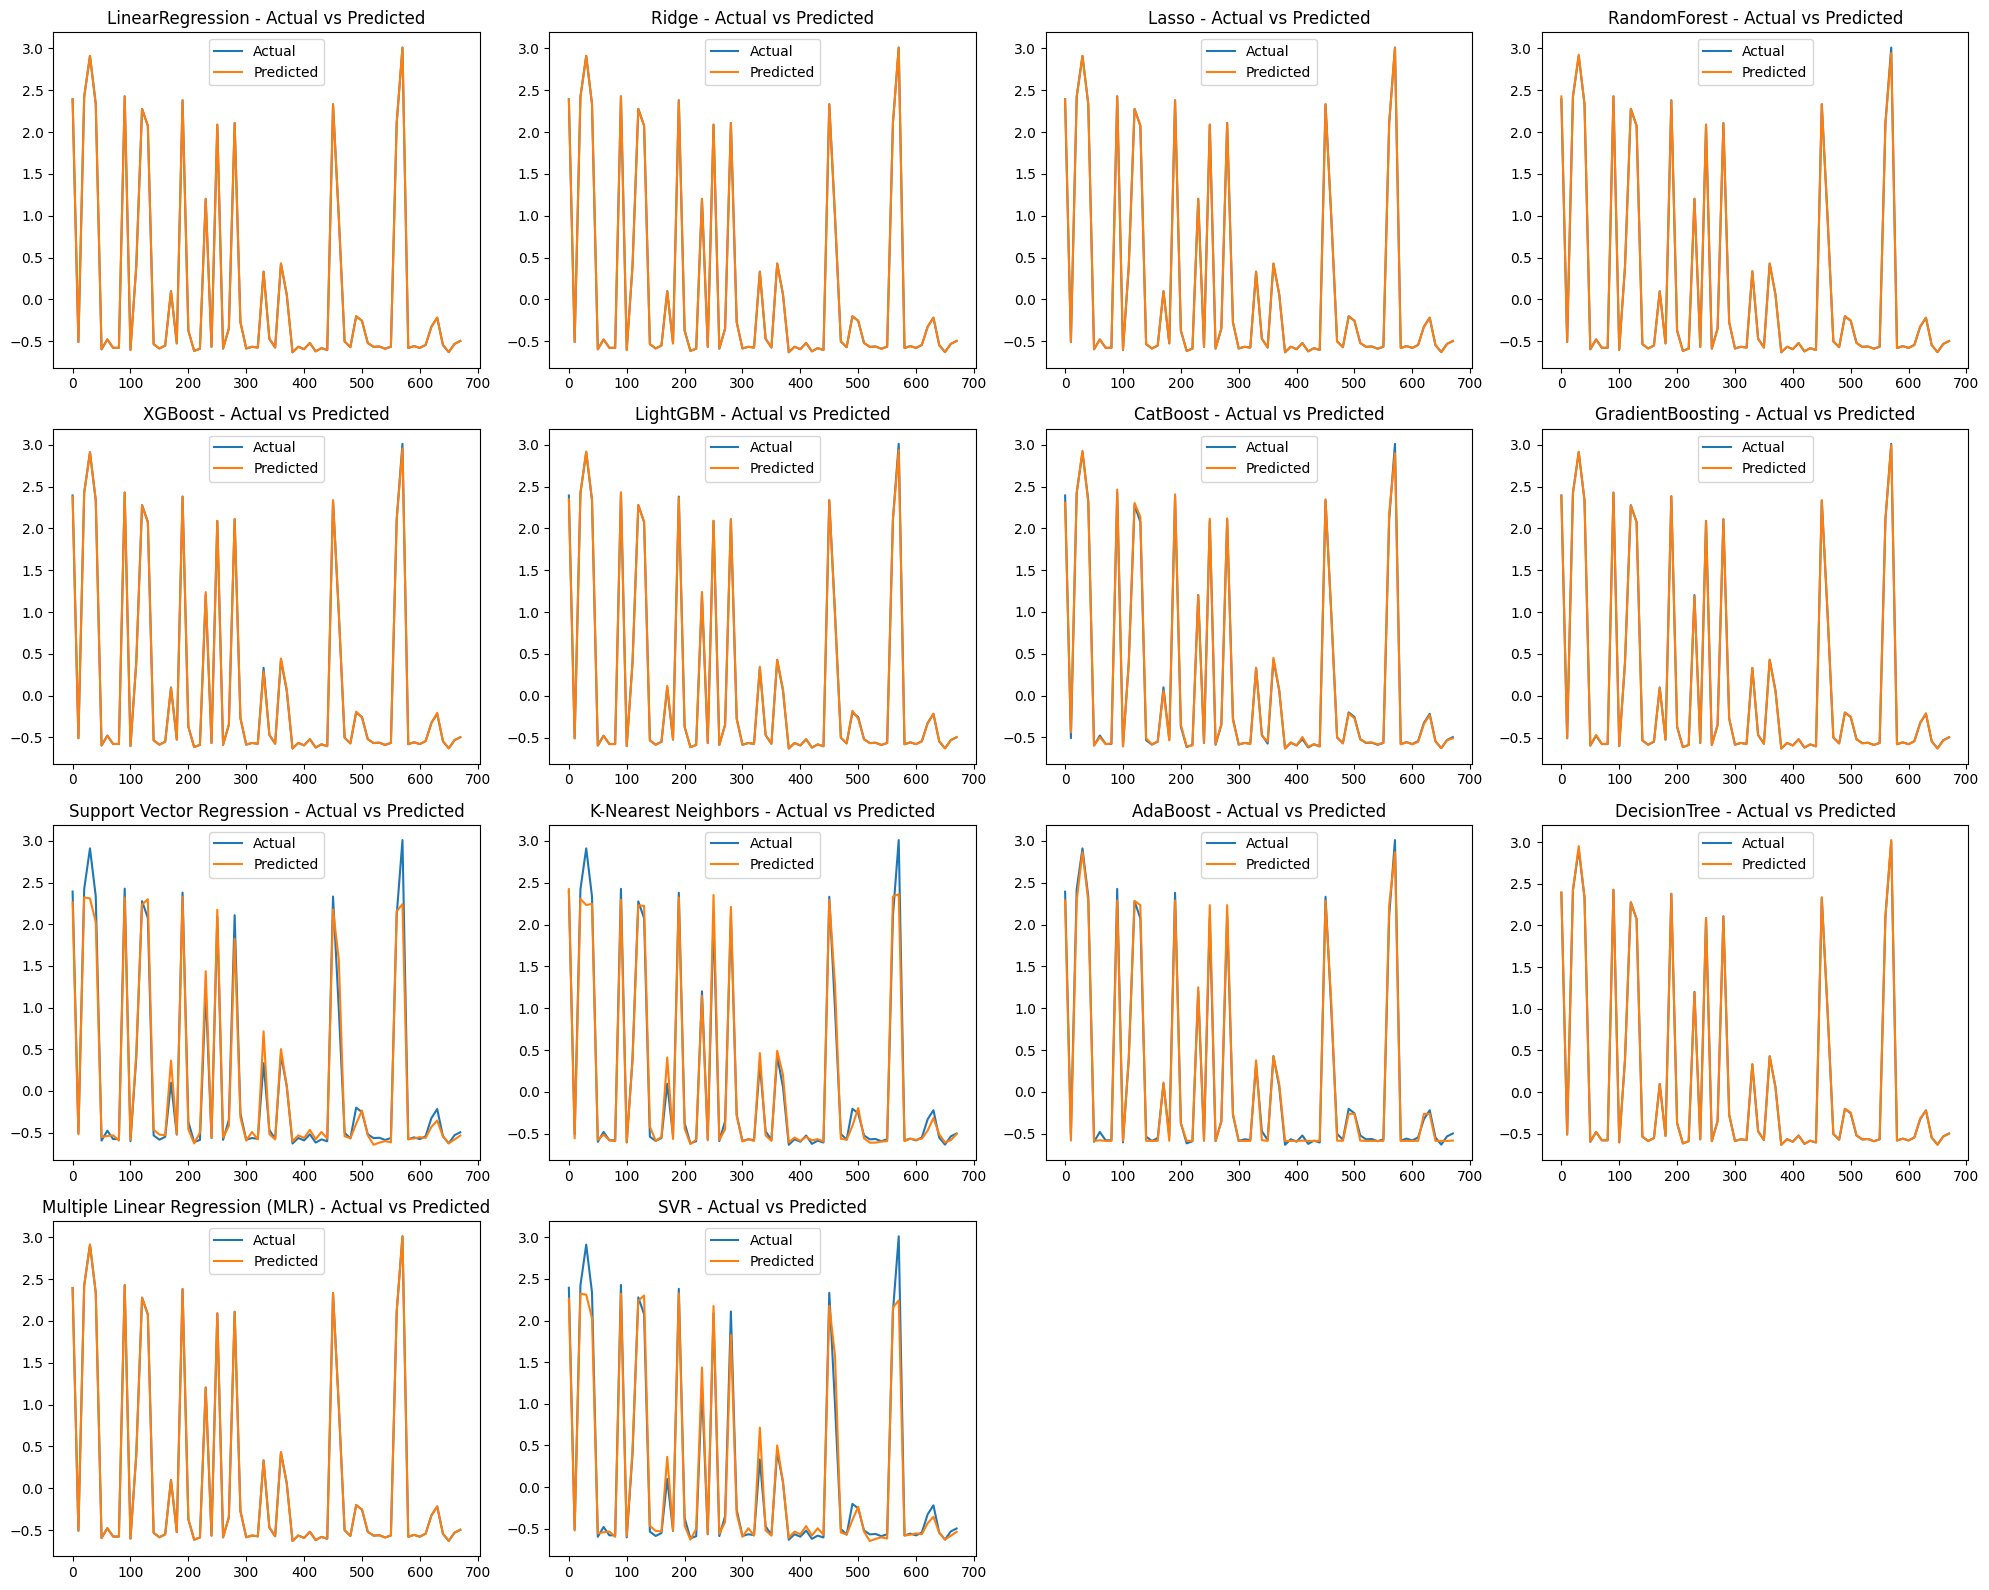

In [13]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [48]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [134]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [49]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [50]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [51]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)
                
                train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())
                
                print(f"\nModel: {name} | Epoch: {epoch}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
    return history

In [52]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor)
                y_test_pred  = model(X_test_tensor)

                train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_rmse = np.sqrt(train_mse)
                test_rmse  = np.sqrt(test_mse)
                train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
                test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
                train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
                test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

                history.append({
                    "Model": name,
                    "Epoch": epoch,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Train RMSE": train_rmse,
                    "Test RMSE": test_rmse,
                    "Train MAE": train_mae,
                    "Test MAE": test_mae,
                    "Train R2": train_r2,
                    "Test R2": test_r2
                })
        
        if epoch % 100 == 0:
            print(f"\nModel: {name} | Epoch: {epoch}")
            print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
            print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history


In [137]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [54]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 32.92it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0014, RMSE: 0.0374, MAE: 0.0261, R2: 0.9986
Test:  MSE: 0.0019, RMSE: 0.0431, MAE: 0.0302, R2: 0.9982


 23%|███████████████████████▍                                                                              | 23/100 [00:00<00:02, 33.94it/s]


Model: Net1 | Epoch: 20
Train: MSE: 0.0006, RMSE: 0.0238, MAE: 0.0168, R2: 0.9994
Test:  MSE: 0.0008, RMSE: 0.0286, MAE: 0.0198, R2: 0.9992


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:01<00:02, 29.02it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0004, RMSE: 0.0190, MAE: 0.0136, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0228, MAE: 0.0161, R2: 0.9995


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:01<00:01, 31.57it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0003, RMSE: 0.0161, MAE: 0.0117, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0203, MAE: 0.0141, R2: 0.9996


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 31.45it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0140, MAE: 0.0101, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0184, MAE: 0.0124, R2: 0.9997


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:02<00:01, 30.49it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0127, MAE: 0.0091, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0163, MAE: 0.0107, R2: 0.9997


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 30.02it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0152, MAE: 0.0099, R2: 0.9998


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:02<00:00, 29.40it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0094, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 30.91it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0090, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0086, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.51it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0097, MAE: 0.0077, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0139, MAE: 0.0098, R2: 0.9998


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 20.47it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0004, RMSE: 0.0200, MAE: 0.0148, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0245, MAE: 0.0177, R2: 0.9994


 23%|███████████████████████▍                                                                              | 23/100 [00:01<00:04, 19.01it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0002, RMSE: 0.0133, MAE: 0.0096, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0185, MAE: 0.0125, R2: 0.9997


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:03, 20.24it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0001, RMSE: 0.0104, MAE: 0.0079, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0155, MAE: 0.0106, R2: 0.9998


 44%|████████████████████████████████████████████▉                                                         | 44/100 [00:02<00:02, 20.50it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0086, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0090, R2: 0.9998


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:02<00:02, 20.16it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0142, MAE: 0.0100, R2: 0.9998


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:01, 19.83it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0131, MAE: 0.0107, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0161, MAE: 0.0122, R2: 0.9997


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:03<00:01, 20.39it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0083, R2: 0.9999


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:04<00:00, 18.84it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0111, MAE: 0.0072, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:04<00:00, 19.27it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0109, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0097, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.63it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0086, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0086, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 14.79it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0002, RMSE: 0.0142, MAE: 0.0108, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0172, MAE: 0.0123, R2: 0.9997


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:05, 14.17it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0126, MAE: 0.0089, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:06, 10.12it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0051, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0095, MAE: 0.0067, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:04, 13.44it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0091, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0083, R2: 0.9999


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:03, 14.64it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0138, MAE: 0.0113, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0144, MAE: 0.0116, R2: 0.9998


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 15.27it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0121, MAE: 0.0094, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0104, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:05<00:01, 15.97it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0113, MAE: 0.0089, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0093, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 16.57it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0082, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0087, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:06<00:00, 16.30it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0058, MAE: 0.0041, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0078, MAE: 0.0052, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.63it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0083, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0118, MAE: 0.0087, R2: 0.9999


 11%|███████████▏                                                                                          | 11/100 [00:01<00:14,  5.97it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0039, RMSE: 0.0627, MAE: 0.0466, R2: 0.9960
Test:  MSE: 0.0044, RMSE: 0.0665, MAE: 0.0498, R2: 0.9957


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:12,  6.37it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0116, RMSE: 0.1076, MAE: 0.0746, R2: 0.9883
Test:  MSE: 0.0110, RMSE: 0.1048, MAE: 0.0729, R2: 0.9894


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:10,  6.62it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0057, RMSE: 0.0754, MAE: 0.0531, R2: 0.9943
Test:  MSE: 0.0057, RMSE: 0.0754, MAE: 0.0532, R2: 0.9945


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:06<00:09,  6.29it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0044, RMSE: 0.0663, MAE: 0.0508, R2: 0.9956
Test:  MSE: 0.0046, RMSE: 0.0682, MAE: 0.0520, R2: 0.9955


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:08<00:07,  6.33it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0043, RMSE: 0.0659, MAE: 0.0587, R2: 0.9956
Test:  MSE: 0.0044, RMSE: 0.0661, MAE: 0.0574, R2: 0.9958


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:09<00:06,  6.36it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0083, RMSE: 0.0911, MAE: 0.0659, R2: 0.9916
Test:  MSE: 0.0086, RMSE: 0.0929, MAE: 0.0687, R2: 0.9916


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:11<00:04,  6.71it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0119, RMSE: 0.1089, MAE: 0.0712, R2: 0.9880
Test:  MSE: 0.0125, RMSE: 0.1119, MAE: 0.0734, R2: 0.9879


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:12<00:02,  6.43it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0159, RMSE: 0.1262, MAE: 0.0720, R2: 0.9840
Test:  MSE: 0.0163, RMSE: 0.1275, MAE: 0.0743, R2: 0.9842


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:14<00:01,  6.46it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0087, RMSE: 0.0932, MAE: 0.0711, R2: 0.9912
Test:  MSE: 0.0086, RMSE: 0.0928, MAE: 0.0716, R2: 0.9917


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


Model: Net4 | Epoch: 100
Train: MSE: 0.0032, RMSE: 0.0569, MAE: 0.0486, R2: 0.9967
Test:  MSE: 0.0031, RMSE: 0.0561, MAE: 0.0477, R2: 0.9970


In [55]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

 16%|████████████████▎                                                                                     | 16/100 [00:00<00:01, 50.12it/s]


Model: Net1 | Epoch: 10
Train: MSE: 0.0069, RMSE: 0.0829, MAE: 0.0610, R2: 0.9931
Test:  MSE: 0.0066, RMSE: 0.0812, MAE: 0.0606, R2: 0.9936

Model: Net1 | Epoch: 20
Train: MSE: 0.0020, RMSE: 0.0450, MAE: 0.0321, R2: 0.9980
Test:  MSE: 0.0023, RMSE: 0.0476, MAE: 0.0344, R2: 0.9978


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:00<00:01, 41.41it/s]


Model: Net1 | Epoch: 30
Train: MSE: 0.0012, RMSE: 0.0344, MAE: 0.0250, R2: 0.9988
Test:  MSE: 0.0014, RMSE: 0.0368, MAE: 0.0271, R2: 0.9987


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:01<00:01, 41.70it/s]


Model: Net1 | Epoch: 40
Train: MSE: 0.0008, RMSE: 0.0283, MAE: 0.0208, R2: 0.9992
Test:  MSE: 0.0009, RMSE: 0.0306, MAE: 0.0228, R2: 0.9991


 56%|█████████████████████████████████████████████████████████                                             | 56/100 [00:01<00:01, 42.07it/s]


Model: Net1 | Epoch: 50
Train: MSE: 0.0006, RMSE: 0.0244, MAE: 0.0179, R2: 0.9994
Test:  MSE: 0.0007, RMSE: 0.0266, MAE: 0.0199, R2: 0.9993


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:01<00:00, 40.46it/s]


Model: Net1 | Epoch: 60
Train: MSE: 0.0005, RMSE: 0.0218, MAE: 0.0159, R2: 0.9995
Test:  MSE: 0.0006, RMSE: 0.0240, MAE: 0.0180, R2: 0.9994


 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [00:01<00:00, 42.63it/s]


Model: Net1 | Epoch: 70
Train: MSE: 0.0004, RMSE: 0.0199, MAE: 0.0145, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0222, MAE: 0.0166, R2: 0.9995


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 86/100 [00:02<00:00, 41.72it/s]


Model: Net1 | Epoch: 80
Train: MSE: 0.0003, RMSE: 0.0184, MAE: 0.0134, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0208, MAE: 0.0154, R2: 0.9996


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:02<00:00, 43.11it/s]


Model: Net1 | Epoch: 90
Train: MSE: 0.0003, RMSE: 0.0171, MAE: 0.0124, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0197, MAE: 0.0143, R2: 0.9996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.27it/s]



Model: Net1 | Epoch: 100
Train: MSE: 0.0003, RMSE: 0.0160, MAE: 0.0116, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0187, MAE: 0.0135, R2: 0.9997


 12%|████████████▏                                                                                         | 12/100 [00:00<00:02, 36.27it/s]


Model: Net2 | Epoch: 10
Train: MSE: 0.0019, RMSE: 0.0436, MAE: 0.0319, R2: 0.9981
Test:  MSE: 0.0021, RMSE: 0.0457, MAE: 0.0335, R2: 0.9980


 26%|██████████████████████████▌                                                                           | 26/100 [00:00<00:02, 27.93it/s]


Model: Net2 | Epoch: 20
Train: MSE: 0.0007, RMSE: 0.0271, MAE: 0.0199, R2: 0.9993
Test:  MSE: 0.0009, RMSE: 0.0303, MAE: 0.0215, R2: 0.9991


 34%|██████████████████████████████████▋                                                                   | 34/100 [00:01<00:02, 30.33it/s]


Model: Net2 | Epoch: 30
Train: MSE: 0.0005, RMSE: 0.0213, MAE: 0.0156, R2: 0.9995
Test:  MSE: 0.0007, RMSE: 0.0255, MAE: 0.0174, R2: 0.9994


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:01<00:01, 33.72it/s]


Model: Net2 | Epoch: 40
Train: MSE: 0.0003, RMSE: 0.0180, MAE: 0.0132, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0223, MAE: 0.0148, R2: 0.9995


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 34.92it/s]


Model: Net2 | Epoch: 50
Train: MSE: 0.0002, RMSE: 0.0151, MAE: 0.0109, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0202, MAE: 0.0131, R2: 0.9996


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:02<00:00, 35.72it/s]


Model: Net2 | Epoch: 60
Train: MSE: 0.0002, RMSE: 0.0134, MAE: 0.0098, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0191, MAE: 0.0123, R2: 0.9996


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 35.50it/s]


Model: Net2 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0121, MAE: 0.0090, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0113, R2: 0.9997


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 86/100 [00:02<00:00, 35.83it/s]


Model: Net2 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0171, MAE: 0.0108, R2: 0.9997


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:02<00:00, 35.38it/s]


Model: Net2 | Epoch: 90
Train: MSE: 0.0001, RMSE: 0.0108, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0163, MAE: 0.0103, R2: 0.9997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.65it/s]



Model: Net2 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0155, MAE: 0.0097, R2: 0.9998


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 18.49it/s]


Model: Net3 | Epoch: 10
Train: MSE: 0.0008, RMSE: 0.0290, MAE: 0.0211, R2: 0.9992
Test:  MSE: 0.0009, RMSE: 0.0294, MAE: 0.0209, R2: 0.9992


 24%|████████████████████████▍                                                                             | 24/100 [00:01<00:03, 23.32it/s]


Model: Net3 | Epoch: 20
Train: MSE: 0.0003, RMSE: 0.0175, MAE: 0.0127, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0194, MAE: 0.0135, R2: 0.9996


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 26.42it/s]


Model: Net3 | Epoch: 30
Train: MSE: 0.0002, RMSE: 0.0135, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0161, MAE: 0.0109, R2: 0.9997


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:02, 27.48it/s]


Model: Net3 | Epoch: 40
Train: MSE: 0.0001, RMSE: 0.0108, MAE: 0.0077, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0092, R2: 0.9998


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:01, 29.17it/s]


Model: Net3 | Epoch: 50
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0127, MAE: 0.0083, R2: 0.9998


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:02<00:01, 29.14it/s]


Model: Net3 | Epoch: 60
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0062, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0078, R2: 0.9999


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 29.14it/s]


Model: Net3 | Epoch: 70
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0082, R2: 0.9999


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 29.78it/s]


Model: Net3 | Epoch: 80
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0053, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0075, R2: 0.9999


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:03<00:00, 29.67it/s]


Model: Net3 | Epoch: 90
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0069, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.99it/s]



Model: Net3 | Epoch: 100
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0060, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0078, R2: 0.9999


 12%|████████████▏                                                                                         | 12/100 [00:00<00:07, 12.08it/s]


Model: Net4 | Epoch: 10
Train: MSE: 0.0028, RMSE: 0.0528, MAE: 0.0429, R2: 0.9972
Test:  MSE: 0.0030, RMSE: 0.0547, MAE: 0.0439, R2: 0.9971


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:07, 10.78it/s]


Model: Net4 | Epoch: 20
Train: MSE: 0.0044, RMSE: 0.0663, MAE: 0.0469, R2: 0.9956
Test:  MSE: 0.0047, RMSE: 0.0689, MAE: 0.0484, R2: 0.9954


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:05, 12.33it/s]


Model: Net4 | Epoch: 30
Train: MSE: 0.0033, RMSE: 0.0572, MAE: 0.0491, R2: 0.9967
Test:  MSE: 0.0031, RMSE: 0.0561, MAE: 0.0468, R2: 0.9970


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:03<00:04, 12.11it/s]


Model: Net4 | Epoch: 40
Train: MSE: 0.0043, RMSE: 0.0657, MAE: 0.0457, R2: 0.9957
Test:  MSE: 0.0045, RMSE: 0.0668, MAE: 0.0465, R2: 0.9957


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:04<00:04, 11.03it/s]


Model: Net4 | Epoch: 50
Train: MSE: 0.0014, RMSE: 0.0380, MAE: 0.0296, R2: 0.9985
Test:  MSE: 0.0016, RMSE: 0.0397, MAE: 0.0300, R2: 0.9985


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:05<00:03, 12.65it/s]


Model: Net4 | Epoch: 60
Train: MSE: 0.0052, RMSE: 0.0721, MAE: 0.0586, R2: 0.9948
Test:  MSE: 0.0050, RMSE: 0.0708, MAE: 0.0575, R2: 0.9951


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:06<00:02, 12.62it/s]


Model: Net4 | Epoch: 70
Train: MSE: 0.0079, RMSE: 0.0889, MAE: 0.0577, R2: 0.9920
Test:  MSE: 0.0081, RMSE: 0.0901, MAE: 0.0588, R2: 0.9921


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:06<00:01, 12.70it/s]


Model: Net4 | Epoch: 80
Train: MSE: 0.0063, RMSE: 0.0792, MAE: 0.0593, R2: 0.9937
Test:  MSE: 0.0061, RMSE: 0.0781, MAE: 0.0588, R2: 0.9941


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:07<00:00, 12.35it/s]


Model: Net4 | Epoch: 90
Train: MSE: 0.0104, RMSE: 0.1018, MAE: 0.0590, R2: 0.9896
Test:  MSE: 0.0109, RMSE: 0.1042, MAE: 0.0611, R2: 0.9895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.94it/s]



Model: Net4 | Epoch: 100
Train: MSE: 0.0090, RMSE: 0.0947, MAE: 0.0735, R2: 0.9909
Test:  MSE: 0.0089, RMSE: 0.0942, MAE: 0.0730, R2: 0.9914


 16%|████████████████▎                                                                                     | 16/100 [00:00<00:02, 31.04it/s]


Model: FNN | Epoch: 10
Train: MSE: 0.0104, RMSE: 0.1017, MAE: 0.0785, R2: 0.9896
Test:  MSE: 0.0091, RMSE: 0.0952, MAE: 0.0724, R2: 0.9912


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 31.37it/s]


Model: FNN | Epoch: 20
Train: MSE: 0.0114, RMSE: 0.1069, MAE: 0.0736, R2: 0.9885
Test:  MSE: 0.0109, RMSE: 0.1043, MAE: 0.0720, R2: 0.9895


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:01<00:02, 30.71it/s]


Model: FNN | Epoch: 30
Train: MSE: 0.0057, RMSE: 0.0755, MAE: 0.0548, R2: 0.9942
Test:  MSE: 0.0055, RMSE: 0.0744, MAE: 0.0541, R2: 0.9946


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:01, 29.36it/s]


Model: FNN | Epoch: 40
Train: MSE: 0.0048, RMSE: 0.0693, MAE: 0.0524, R2: 0.9952
Test:  MSE: 0.0049, RMSE: 0.0699, MAE: 0.0529, R2: 0.9953


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 30.28it/s]


Model: FNN | Epoch: 50
Train: MSE: 0.0060, RMSE: 0.0775, MAE: 0.0558, R2: 0.9939
Test:  MSE: 0.0063, RMSE: 0.0792, MAE: 0.0575, R2: 0.9939


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:02<00:01, 31.24it/s]


Model: FNN | Epoch: 60
Train: MSE: 0.0041, RMSE: 0.0641, MAE: 0.0485, R2: 0.9959
Test:  MSE: 0.0044, RMSE: 0.0663, MAE: 0.0495, R2: 0.9957


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 31.23it/s]


Model: FNN | Epoch: 70
Train: MSE: 0.0033, RMSE: 0.0578, MAE: 0.0433, R2: 0.9966
Test:  MSE: 0.0038, RMSE: 0.0615, MAE: 0.0453, R2: 0.9963


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 86/100 [00:02<00:00, 31.26it/s]


Model: FNN | Epoch: 80
Train: MSE: 0.0029, RMSE: 0.0542, MAE: 0.0405, R2: 0.9970
Test:  MSE: 0.0034, RMSE: 0.0579, MAE: 0.0427, R2: 0.9967


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:03<00:00, 31.24it/s]


Model: FNN | Epoch: 90
Train: MSE: 0.0031, RMSE: 0.0555, MAE: 0.0397, R2: 0.9969
Test:  MSE: 0.0035, RMSE: 0.0596, MAE: 0.0426, R2: 0.9966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.82it/s]



Model: FNN | Epoch: 100
Train: MSE: 0.0044, RMSE: 0.0660, MAE: 0.0462, R2: 0.9956
Test:  MSE: 0.0047, RMSE: 0.0688, MAE: 0.0488, R2: 0.9954


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 28.72it/s]


Model: DeepFNN | Epoch: 10
Train: MSE: 0.0105, RMSE: 0.1025, MAE: 0.0813, R2: 0.9894
Test:  MSE: 0.0110, RMSE: 0.1051, MAE: 0.0832, R2: 0.9893


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 28.63it/s]


Model: DeepFNN | Epoch: 20
Train: MSE: 0.0058, RMSE: 0.0761, MAE: 0.0544, R2: 0.9942
Test:  MSE: 0.0066, RMSE: 0.0811, MAE: 0.0589, R2: 0.9936


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 28.73it/s]


Model: DeepFNN | Epoch: 30
Train: MSE: 0.0140, RMSE: 0.1182, MAE: 0.0880, R2: 0.9859
Test:  MSE: 0.0147, RMSE: 0.1211, MAE: 0.0909, R2: 0.9858


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 28.28it/s]


Model: DeepFNN | Epoch: 40
Train: MSE: 0.0066, RMSE: 0.0814, MAE: 0.0549, R2: 0.9933
Test:  MSE: 0.0072, RMSE: 0.0850, MAE: 0.0582, R2: 0.9930


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 24.83it/s]


Model: DeepFNN | Epoch: 50
Train: MSE: 0.0049, RMSE: 0.0703, MAE: 0.0511, R2: 0.9950
Test:  MSE: 0.0053, RMSE: 0.0726, MAE: 0.0528, R2: 0.9949


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 24.81it/s]


Model: DeepFNN | Epoch: 60
Train: MSE: 0.0059, RMSE: 0.0769, MAE: 0.0576, R2: 0.9940
Test:  MSE: 0.0064, RMSE: 0.0797, MAE: 0.0590, R2: 0.9938


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:02<00:01, 23.81it/s]


Model: DeepFNN | Epoch: 70
Train: MSE: 0.0057, RMSE: 0.0758, MAE: 0.0577, R2: 0.9942
Test:  MSE: 0.0061, RMSE: 0.0779, MAE: 0.0591, R2: 0.9941


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 26.50it/s]


Model: DeepFNN | Epoch: 80
Train: MSE: 0.0033, RMSE: 0.0578, MAE: 0.0444, R2: 0.9966
Test:  MSE: 0.0035, RMSE: 0.0593, MAE: 0.0453, R2: 0.9966


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 26.91it/s]


Model: DeepFNN | Epoch: 90
Train: MSE: 0.0022, RMSE: 0.0472, MAE: 0.0350, R2: 0.9978
Test:  MSE: 0.0023, RMSE: 0.0480, MAE: 0.0349, R2: 0.9978


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.23it/s]


Model: DeepFNN | Epoch: 100
Train: MSE: 0.0046, RMSE: 0.0680, MAE: 0.0477, R2: 0.9953
Test:  MSE: 0.0048, RMSE: 0.0694, MAE: 0.0482, R2: 0.9953


In [56]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [57]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     90   0.000081  0.000176    0.008995   0.013283   0.006533   
1  Net2     80   0.000038  0.000123    0.006130   0.011091   0.004723   
2  Net3     90   0.000034  0.000060    0.005796   0.007755   0.004144   
3  Net4    100   0.003243  0.003145    0.056944   0.056077   0.048576   

   Test MAE  Train R2   Test R2  
0  0.008565  0.999918  0.999829  
1  0.007173  0.999962  0.999881  
2  0.005211  0.999966  0.999942  
3  0.047703  0.996730  0.996955

In [58]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     90   0.002225  0.002299    0.047167   0.047953   0.035036   
1      FNN     80   0.002934  0.003356    0.054164   0.057935   0.040491   
2     Net1    100   0.000257  0.000351    0.016016   0.018737   0.011611   
3     Net2    100   0.000086  0.000239    0.009284   0.015450   0.006870   
4     Net3     90   0.000037  0.000116    0.006107   0.010780   0.004699   
5     Net4     50   0.001441  0.001577    0.037961   0.039715   0.029571   

   Test MAE  Train R2   Test R2  
0  0.034911  0.997757  0.997773  
1  0.042715  0.997042  0.996750  
2  0.013502  0.999741  0.999660  
3  0.009654  0.999913  0.999769  
4  0.006905  0.999962  0.999887  
5  0.030044  0.998547  0.998473

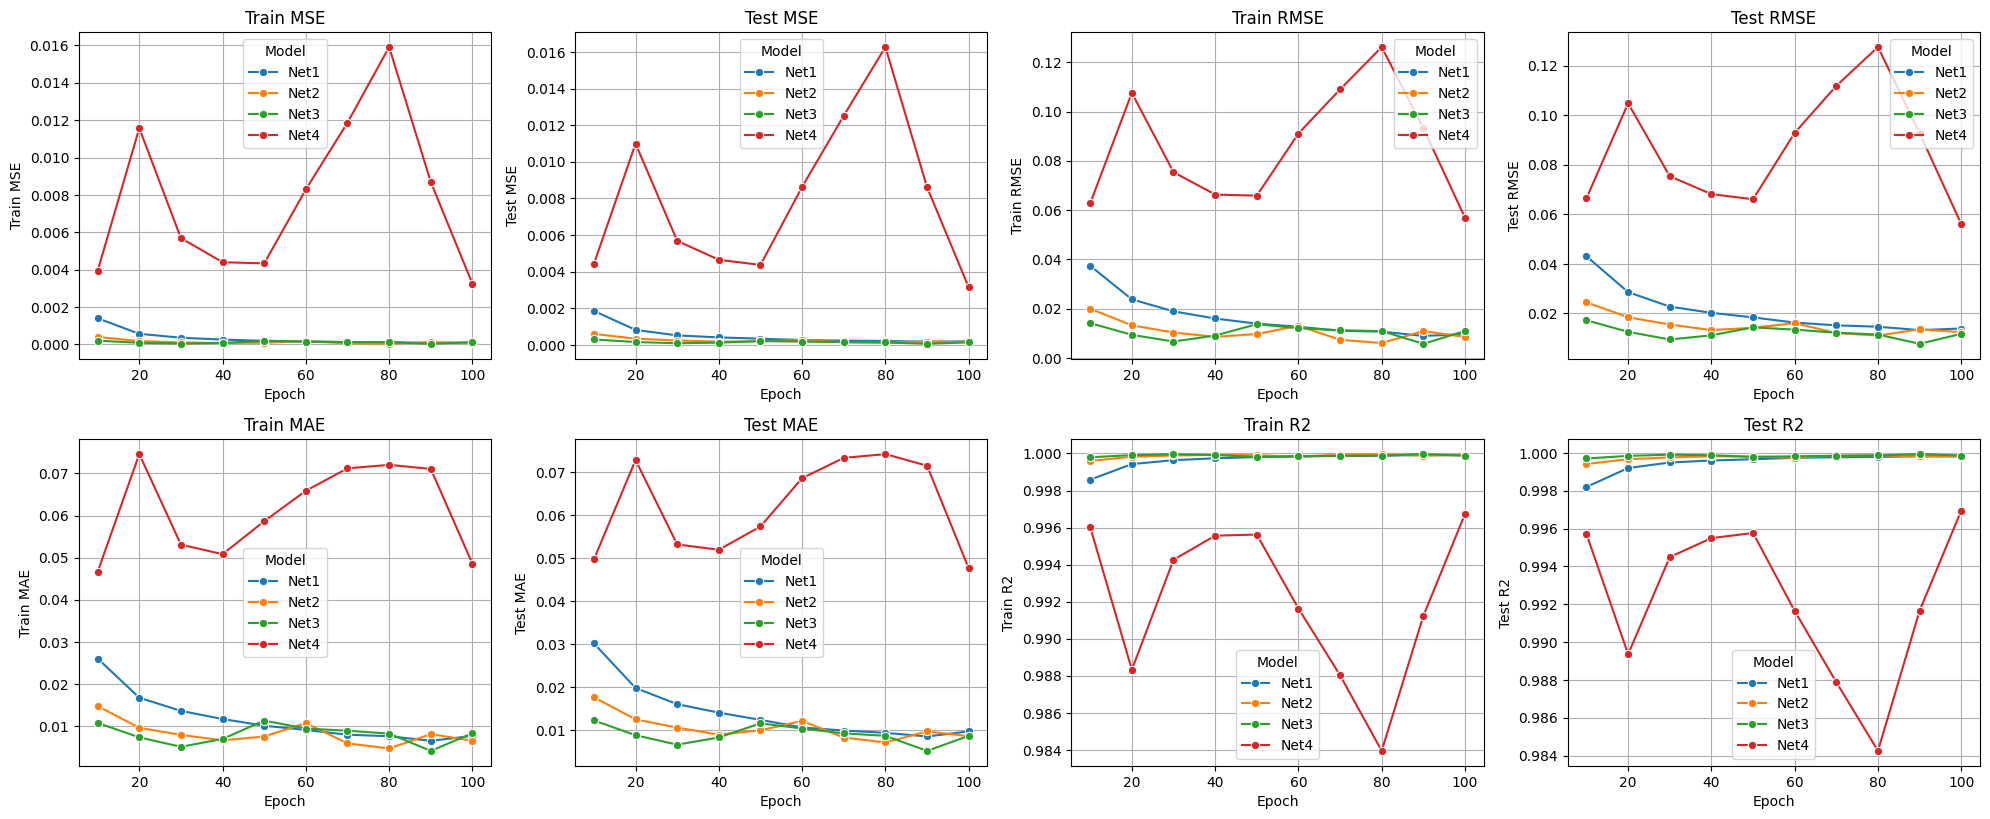

In [172]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

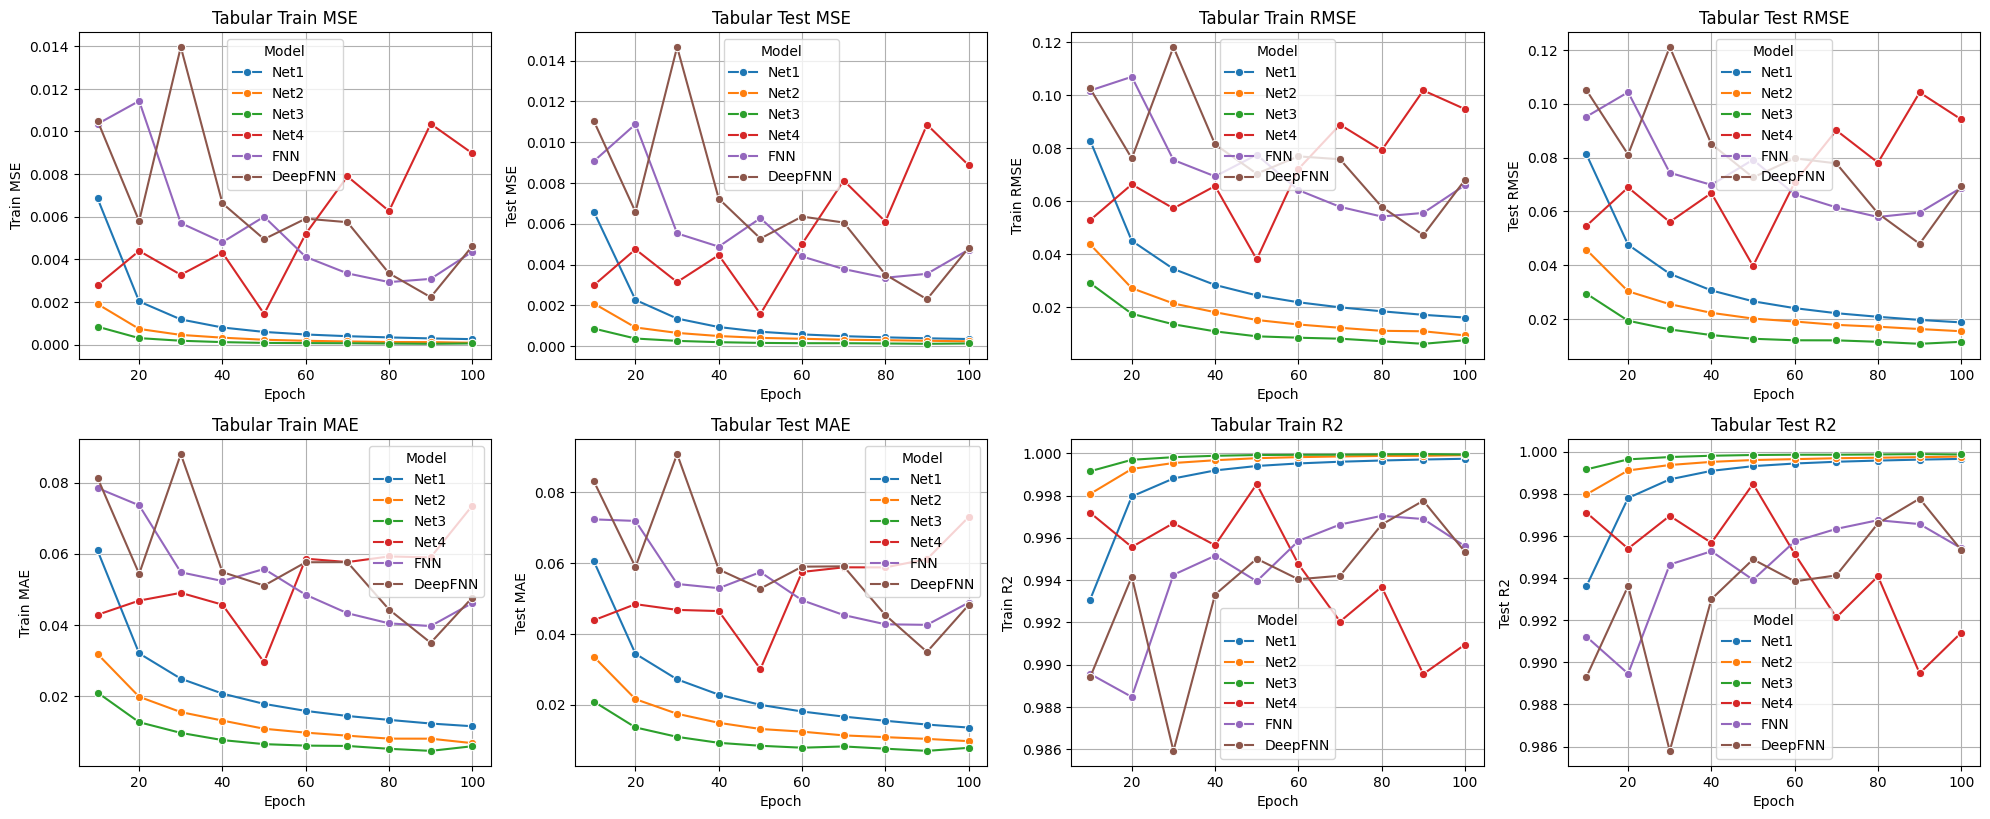

In [173]:
train_figures_tabular = {}

plt.figure(figsize=(20, 16))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("Tabular " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)

plt.tight_layout()
fig = plt.gcf()
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
     TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [100]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [112]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]



Model: TCN | Epoch: 100
Train: MSE: 0.0068, RMSE: 0.0824, MAE: 0.0491, R2: 0.9932
Test:  MSE: 0.0302, RMSE: 0.1738, MAE: 0.1397, R2: 0.9877


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.76it/s]



Model: CNN1D | Epoch: 100
Train: MSE: 0.0143, RMSE: 0.1197, MAE: 0.0674, R2: 0.9857
Test:  MSE: 0.0263, RMSE: 0.1622, MAE: 0.1208, R2: 0.9893


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.26it/s]



Model: GRUNet | Epoch: 100
Train: MSE: 0.0040, RMSE: 0.0635, MAE: 0.0368, R2: 0.9960
Test:  MSE: 0.1440, RMSE: 0.3795, MAE: 0.2579, R2: 0.9413


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.20it/s]



Model: RNNNet | Epoch: 100
Train: MSE: 0.0060, RMSE: 0.0773, MAE: 0.0528, R2: 0.9940
Test:  MSE: 0.3231, RMSE: 0.5684, MAE: 0.3993, R2: 0.8682


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]



Model: CNNLSTM | Epoch: 100
Train: MSE: 0.0128, RMSE: 0.1130, MAE: 0.0648, R2: 0.9873
Test:  MSE: 0.0560, RMSE: 0.2366, MAE: 0.1809, R2: 0.9772


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]



Model: BiLSTMNet | Epoch: 100
Train: MSE: 0.0097, RMSE: 0.0987, MAE: 0.0562, R2: 0.9903
Test:  MSE: 0.1278, RMSE: 0.3575, MAE: 0.2505, R2: 0.9479


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]



Model: DeepLSTMNet | Epoch: 100
Train: MSE: 0.0067, RMSE: 0.0816, MAE: 0.0467, R2: 0.9933
Test:  MSE: 0.0789, RMSE: 0.2808, MAE: 0.2134, R2: 0.9678


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]



Model: CNNBiLSTM | Epoch: 100
Train: MSE: 0.0109, RMSE: 0.1043, MAE: 0.0586, R2: 0.9891
Test:  MSE: 0.0293, RMSE: 0.1713, MAE: 0.1397, R2: 0.9880


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]



Model: GRUCNN | Epoch: 100
Train: MSE: 0.0115, RMSE: 0.1071, MAE: 0.0594, R2: 0.9886
Test:  MSE: 0.0982, RMSE: 0.3133, MAE: 0.1730, R2: 0.9600


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]



Model: TCNLSTM | Epoch: 100
Train: MSE: 0.0045, RMSE: 0.0671, MAE: 0.0412, R2: 0.9955
Test:  MSE: 0.0507, RMSE: 0.2252, MAE: 0.1798, R2: 0.9793


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


Model: Seq2SeqLSTM | Epoch: 100
Train: MSE: 0.0061, RMSE: 0.0781, MAE: 0.0471, R2: 0.9939
Test:  MSE: 0.1486, RMSE: 0.3855, MAE: 0.2926, R2: 0.9394


In [162]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     70   0.011499  0.075763    0.107233   0.275251   0.060070   
1         CNN1D     70   0.014886  0.023948    0.122008   0.154753   0.065828   
2     CNNBiLSTM     10   0.019976  0.029329    0.141335   0.171258   0.074457   
3       CNNLSTM     70   0.015499  0.025387    0.124494   0.159334   0.070342   
4   DeepLSTMNet     30   0.019870  0.022937    0.140961   0.151451   0.072149   
5        GRUCNN     40   0.019474  0.036980    0.139550   0.192303   0.075493   
6        GRUNet     10   0.023952  0.081269    0.154765   0.285078   0.096298   
7        RNNNet     10   0.017355  0.051841    0.131739   0.227686   0.068337   
8   Seq2SeqLSTM     50   0.012740  0.054450    0.112871   0.233344   0.061762   
9           TCN     70   0.007792  0.019435    0.088270   0.139409   0.052326   
10      TCNLSTM     10   0.016116  0.027457    0.126949   0.165700   0.073314   

    Test MAE  Train R2   Test R2  
0   0.198692  0.988516  0.969094  
1   0.112875  0.985134  0.990231  
2   0.131366  0.980051  0.988036  
3   0.123752  0.984522  0.989644  
4   0.127525  0.980156  0.990643  
5   0.120209  0.980552  0.984915  
6   0.225736  0.976079  0.966848  
7   0.164194  0.982668  0.978853  
8   0.186454  0.987277  0.977789  
9   0.109392  0.992219  0.992072  
10  0.141250  0.983905  0.988800

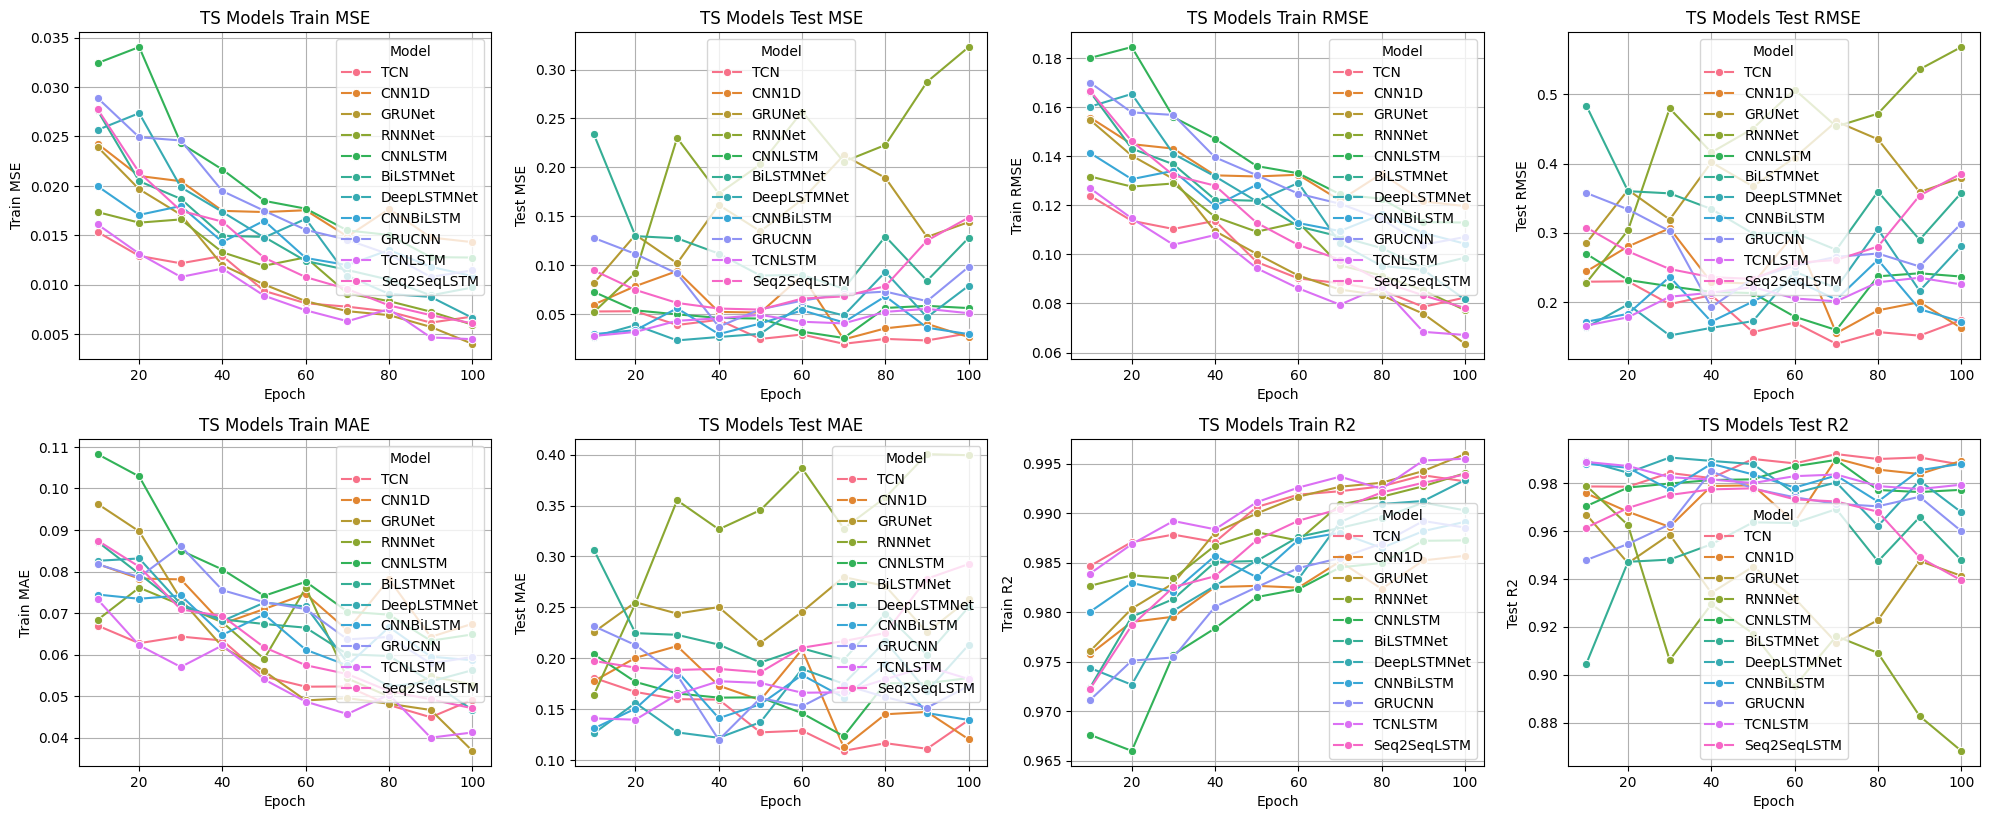

In [196]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

plt.figure(figsize=(20, 16))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o')
    plt.title("TS Models " + metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
plt.tight_layout()
fig = plt.gcf()
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

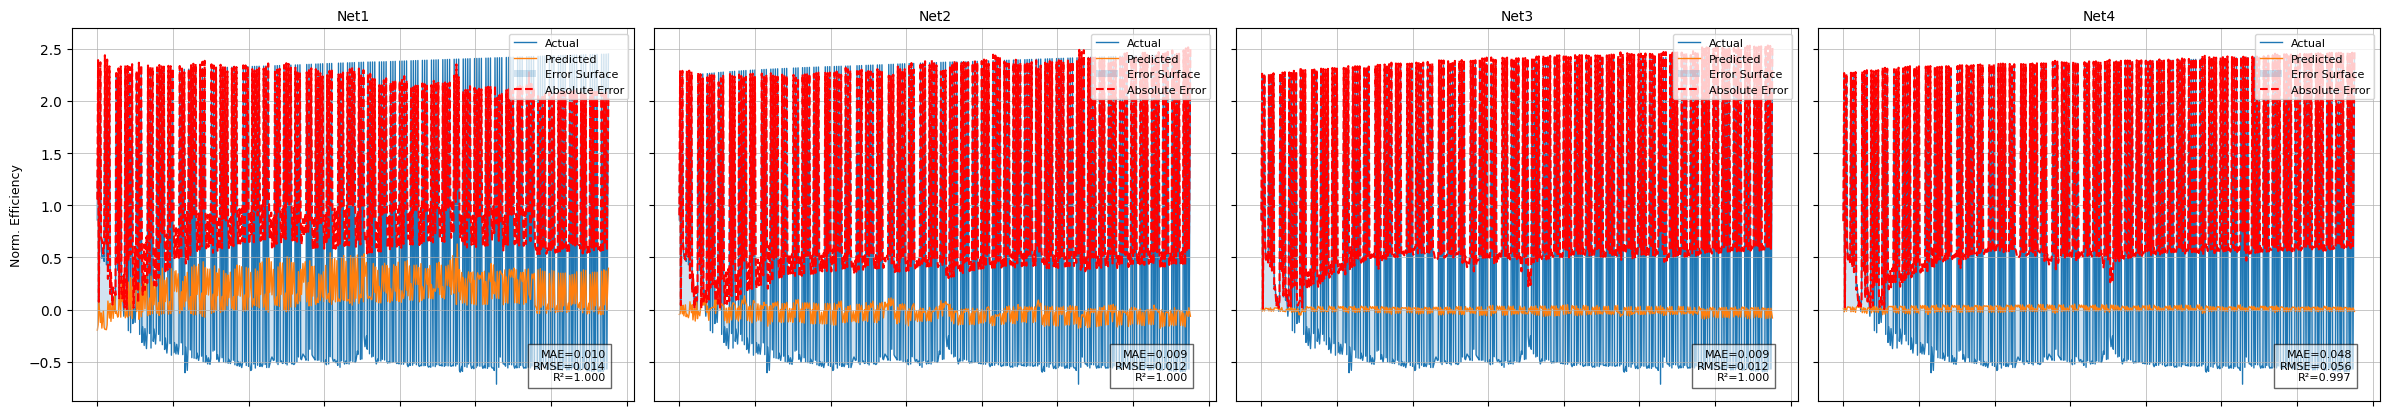

In [179]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

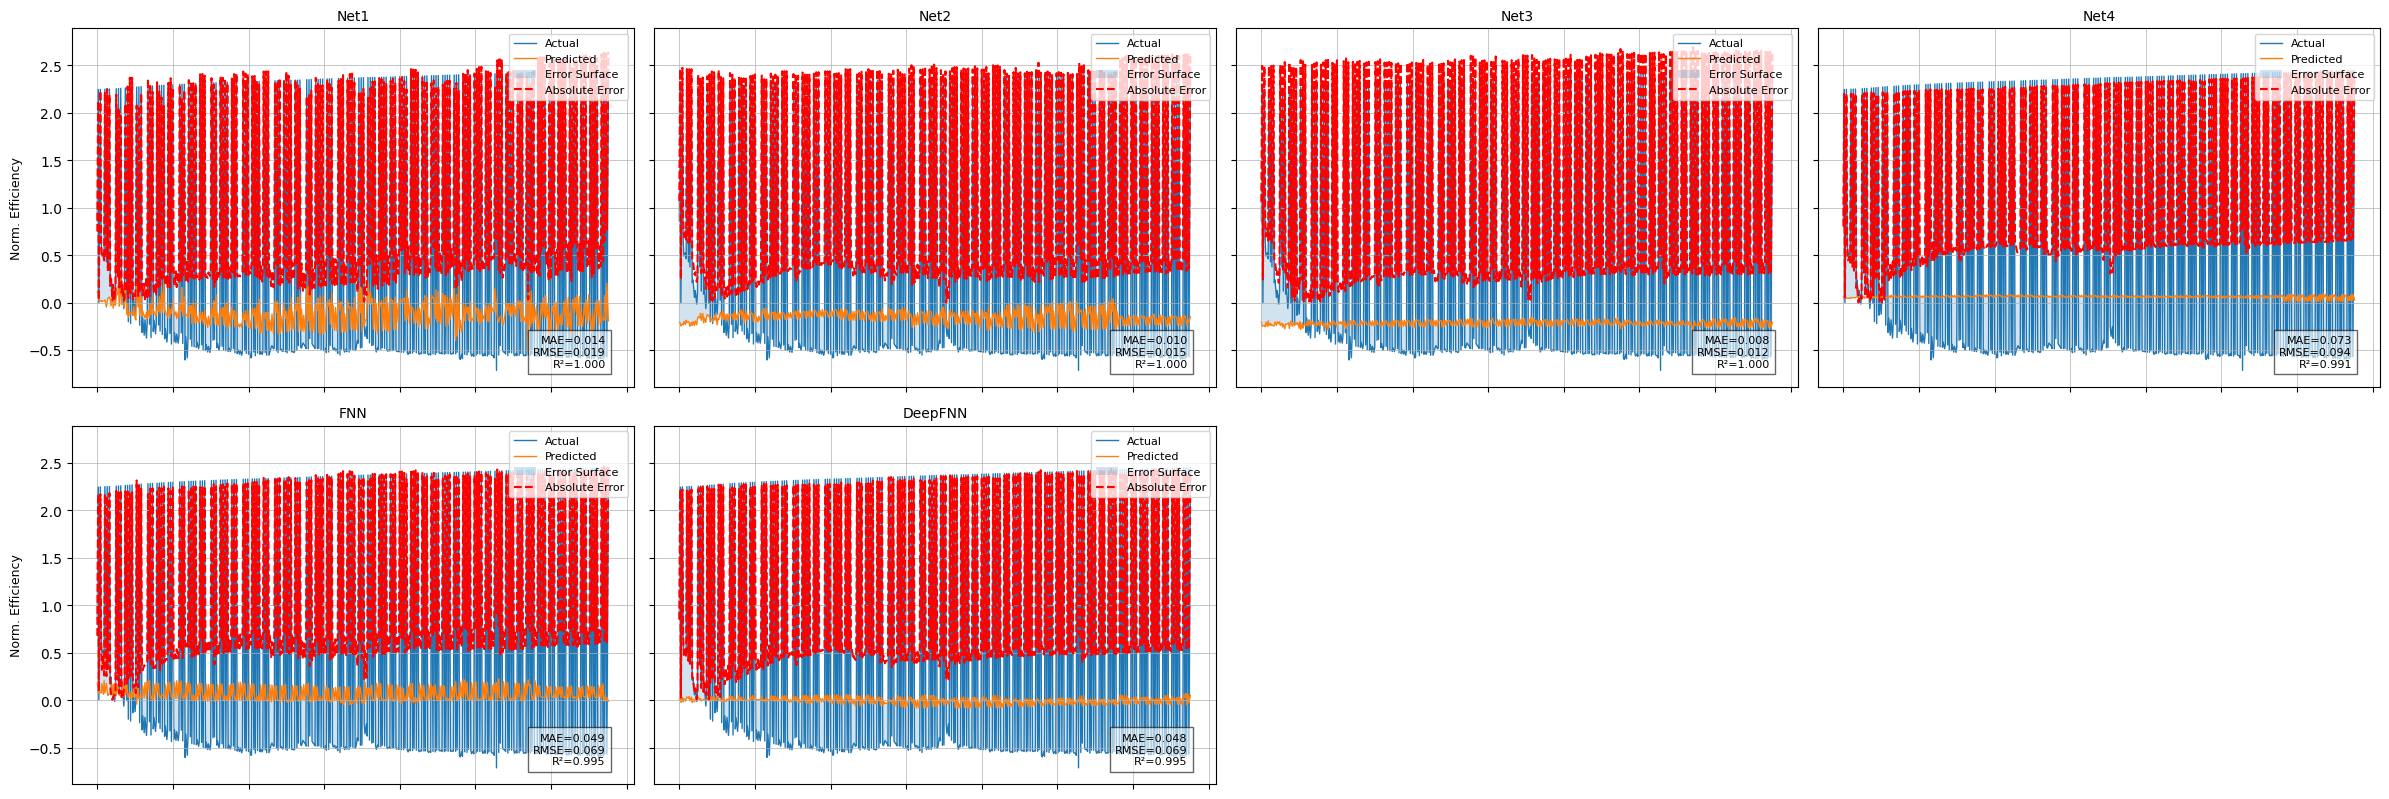

In [180]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(nets_tabular.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_df_tabular
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

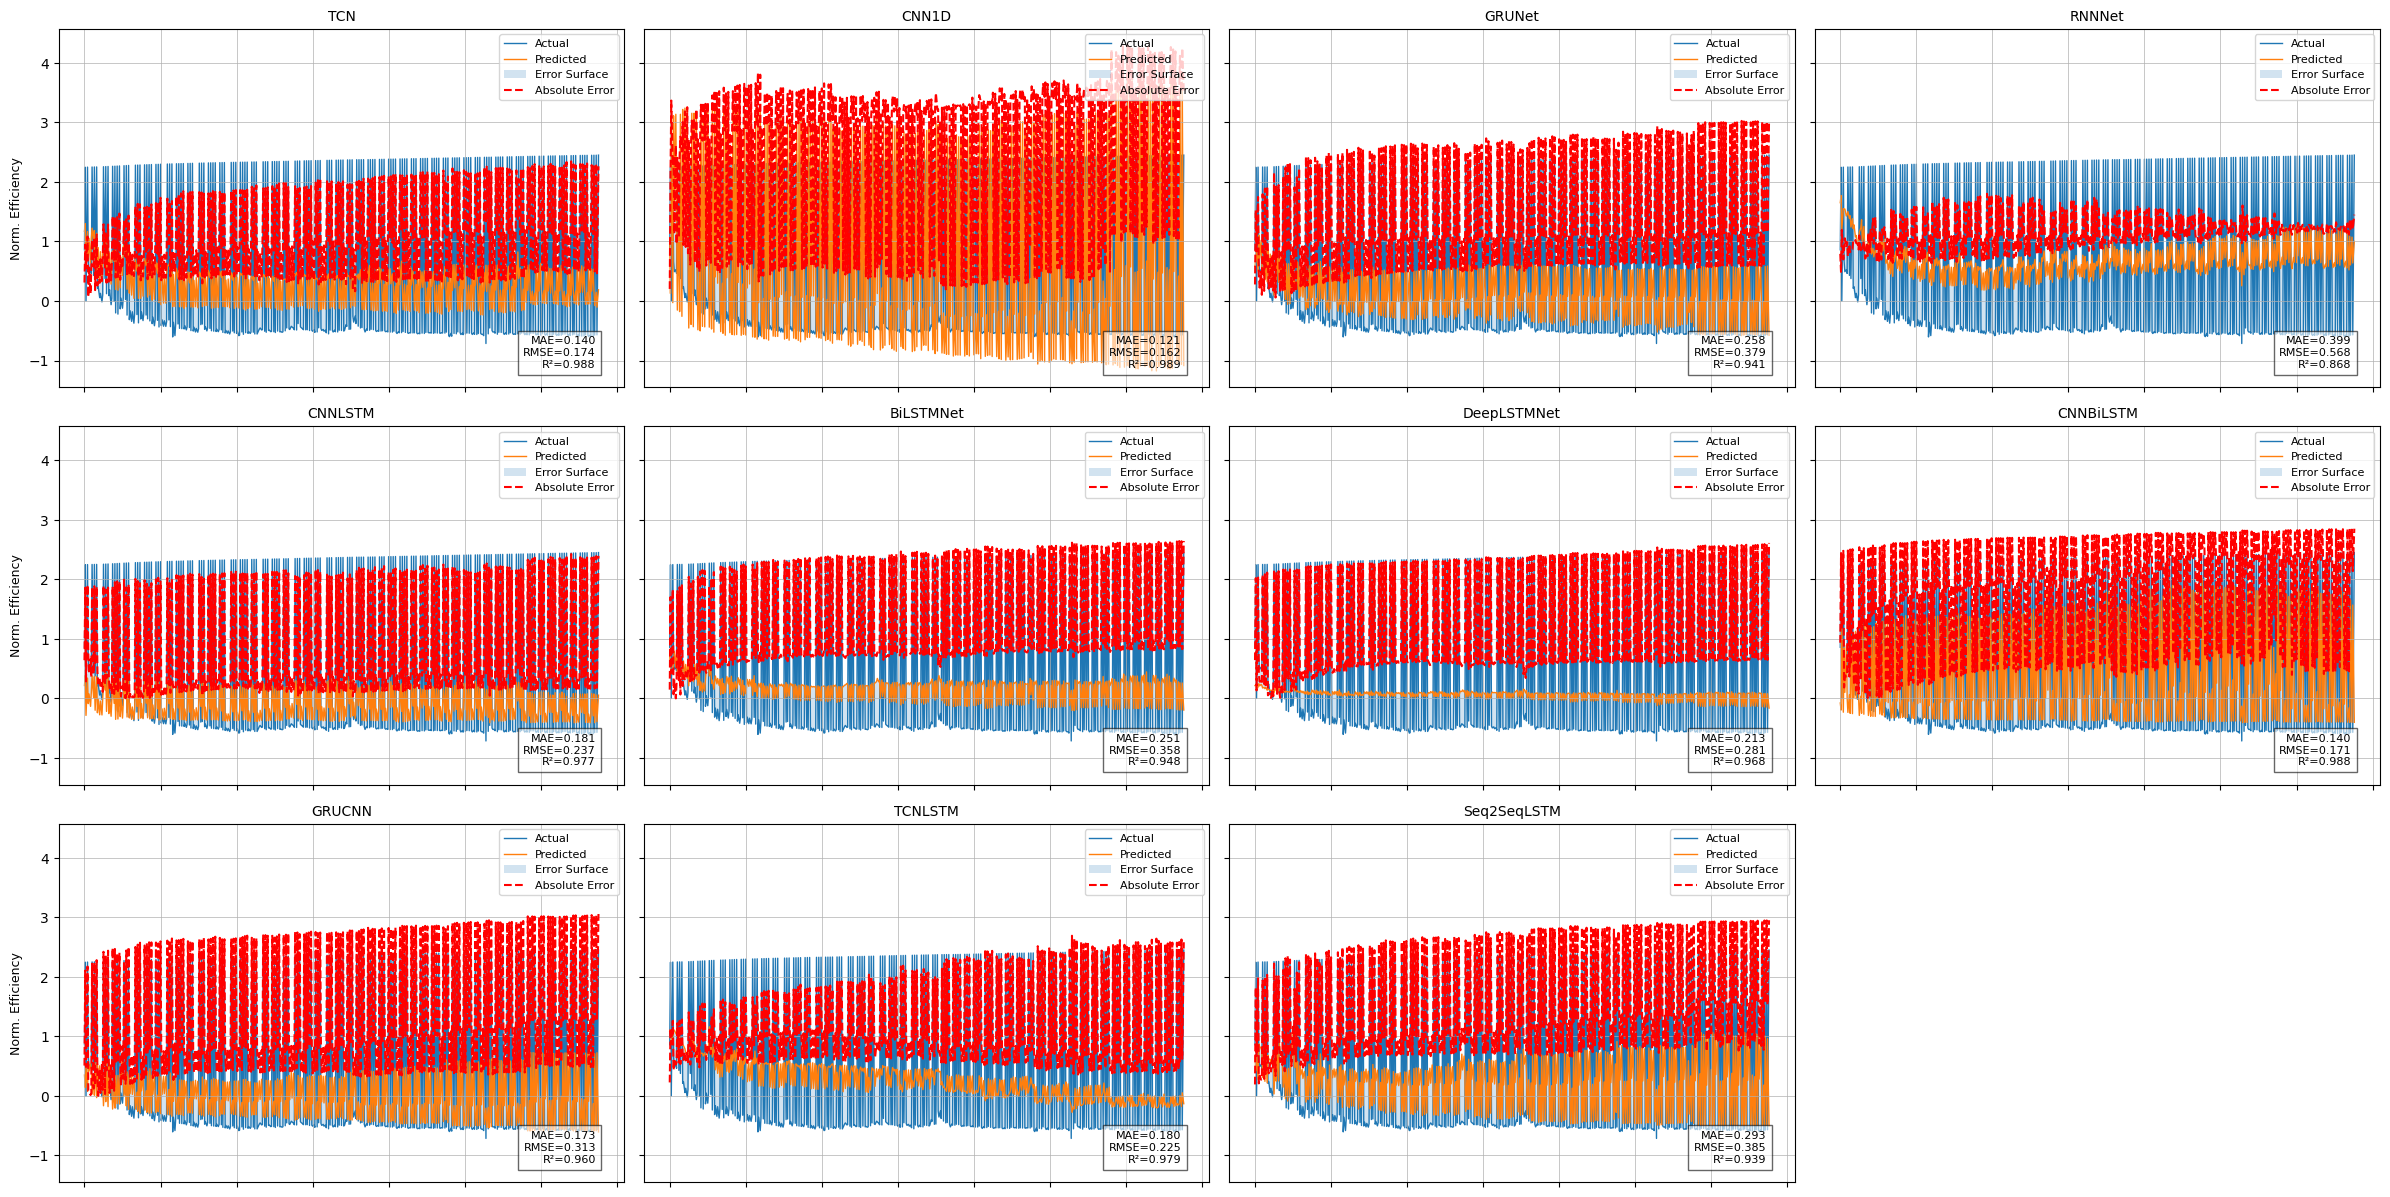

In [181]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 2500   
max_pts = 500     

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[i]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1,
                      min(n_samples, max_pts),
                      dtype=int)

    ax.plot(idx, y_t[idx],   label="Actual",    lw=1, zorder=1)
    ax.plot(idx, y_p[idx],   label="Predicted", lw=1, zorder=1)

    ax.fill_between(idx, y_t[idx], y_p[idx],
                    alpha=0.2, label="Error Surface", zorder=0)
    
    ax.plot(idx, err[idx],
            '--', lw=1.5, color='red',
            label="Absolute Error", zorder=3)

    m = (nn_metrics_ts_df
         .query("Model == @name")
         .sort_values("Epoch")
         .iloc[-1])
    stats = (
        f"MAE={m['Test MAE']:.3f}\n"
        f"RMSE={m['Test RMSE']:.3f}\n"
        f"R²={m['Test R2']:.3f}"
    )
    ax.text(.95, .05, stats,
            transform=ax.transAxes,
            ha='right', va='bottom',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if i % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if i // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper right")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [183]:
for name, model in nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures["Train_Metrics_Nets"]},
        pred_figs={"Predictions": pred_figures_nets["Prediction_Nets"]},
        base_dir=Path("..")
    )


In [187]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs={"Train_Metrics": train_figures_tabular["Train_Metrics_Tabular"]},
        pred_figs={"Predictions": pred_figures_nets_tab["Prediction_Nets_Tab"]},
        base_dir=Path("..")
    )

In [193]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd1",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs={"Train_Metrics": train_figures_ts["Train_Metrics_TS"]},
        pred_figs={"Predictions": pred_figures_nets_ts["Prediction_Nets_TS"]},
        base_dir=Path("..")
    )